## Scanned Document Classification using Deep Learning

<b>Business Problem:</b>  BFSI sectors deal with lots of unstructured scanned documents which are archived in document management systems for further use.For example in Insurance sector, when a policy goes for underwriting, underwriters attached several raw notes with the policy, Insureds also attach various kind of scanned documents like identity card, bank statement, letters etc. In later parts of the policy life cycle if claims are made on a policy, releted scanned documents also archeived.Now it becomes a tedious job to identify a particular document from this vast repository. The goal of this case study is to develop a deep learning based solution which can automatically classify scanned documents.

<b>Data:</b> We will use the RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing) dataset which consists of 400,000 grayscale images in 16 classes, with 25,000 images per class. There are 320,000 training images, 40,000 validation images, and 40,000 test images. The images are sized so their largest dimension does not exceed 1000 pixels.             

link : https://www.cs.cmu.edu/~aharley/rvl-cdip/

<b>Business-ML problem mapping:</b> We can map the business problem as a multi class classification problem. There are 16 classes in the current dataset.The dataset is well balanced.

<b>Technical Requirments:</b> 1. Moderate latency criteria.                                                                                                                               2. No specific interpretibility requirments.

<b>KPI:</b> Accuracy (primary), F1-Score (Micro average)-To penalize wronly classified points, Confusion matrix

In [0]:
# Code to unzip the raw data
import tarfile
tar = tarfile.open("rvl-cdip.tar.gz")
tar.extractall()
tar.close()

### Importing Necessary Libraries 

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory

import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import tarfile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
import time
import math
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import log_loss,confusion_matrix
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D,Conv2D,Dropout,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.datasets import load_files
import cv2
import pickle
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


## Data preprocessing

We will create the directory structure comapatible with keras ImageDataGenerator. For further experiments/ in case intra domain transfer models need to be implemented, we will prepare folder structure compatible with both

In [19]:
label_path='labels/'
# This function will create an index file with image paths and labels in csv format
# obtained csv will have two columns path(path to acess the image),label(class of the image)
def create_csv(file_path):
    images=[]
    labels=[]
    label_file=pd.DataFrame(columns=['path','label'],index=None)
    file=open(file_path)
    for ele in file:
        images.append(ele.split(' ')[0])
        labels.append(ele.split(' ')[1].rstrip())
    label_file.path=images
    label_file.label=labels
    return label_file

train_label_path=label_path+'train.txt' 
test_label_path=label_path+'test.txt' 
val_label_path=label_path+'val.txt'
# creating index file for train,test and val dataset
train_label=create_csv(train_label_path)
test_label=create_csv(test_label_path)
val_label=create_csv(val_label_path)
    

In [2]:
# denifing the metadatas
train_dir='train'
test_dir='test'
cv_dir='val'
classes = {'0': 'letter',
 '1': 'form',
 '10': 'budget',
 '11': 'invoice',
 '12': 'presentation',
 '13': 'questionnaire',
 '14': 'resume',
 '15': 'memo',
 '2': 'email',
 '3': 'handwritten',
 '4': 'advertisement',
 '5': 'scientific report',
 '6': 'scientific publication',
 '7': 'specification',
 '8': 'file folder',
 '9': 'news article'}

In [0]:
# Creating train,validation and Test directories
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [0]:
# run this cell to enable intra domain transfer learning
regions = ['Whole','header', 'footer', 'left_body', 'right_body']
for region in regions:
    os.mkdir('train/'+region)
    os.mkdir('val/'+region)
classes_name=[v for (k,v) in classes.items()]
for region in regions:
    for label in classes_name:
        os.mkdir('train/'+region+'/'+label)
        os.mkdir('val/'+region+'/'+label)

In [11]:
# Moving files for test directory from common directory
folders=[classes[str(i)] for i in range(16)]
for folder in folders:
    if(os.path.exists('test/'+folder)== False):
        os.mkdir('test/'+folder)
for i in tqdm(range(len(test_label))):
    if(os.path.exists('images/'+test_label.iloc[i].path)):
        source='images/'+test_label.iloc[i].path
        dest='test/'+classes[str(test_label.iloc[i].label)]
        if(os.path.exists(dest+'/'+source.split('/')[-1])==False):
            shutil.move(source,dest)
        

In [12]:
# # Moving files for train directory from common directory
for i in tqdm(range(len(train_label))):
    if(os.path.exists('images/'+train_label.iloc[i].path)):
        source='images/'+train_label.iloc[i].path
        dest='train/Whole/'+classes[str(train_label.iloc[i].label)]
        if(os.path.exists(dest+'/'+source.split('/')[-1])==False):
            shutil.move(source,dest)

In [17]:
#  Moving files for validation directory from common directory
for i in tqdm(range(len(val_label))):
    if(os.path.exists('images/'+val_label.iloc[i].path)):
        source='images/'+val_label.iloc[i].path
        dest='val/Whole/'+classes[str(val_label.iloc[i].label)]
        if(os.path.exists(dest+'/'+source.split('/')[-1])==False):
            shutil.move(source,dest)

In [18]:
val_dir='val/Whole'
count,limit=0,2000
for folder in tqdm(os.listdir(val_dir)):
  #os.shuffle(val_dir+'/'+folder)
  for image in os.listdir(val_dir+'/'+folder):
        img = cv2.imread(val_dir+'/'+folder+'/'+image,0)
        height = img.shape[0]
        width = img.shape[1]
        header = img[0:(int(height*0.33)), 0:width]
        footer = img[int(height*0.67):height, 0:width]
        left_body = img[int(height*0.33):int(height*0.67), 0:int(width*0.5)]
        right_body = img[int(height*0.33):int(height*0.67), int(width*0.5):width]
        header_path='val/header/'+folder+'/'+image.split('/')[-1]
        footer_path='val/footer/'+folder+'/'+image.split('/')[-1]
        left_path='val/left_body/'+folder+'/'+image.split('/')[-1]
        right_path='val/right_body/'+folder+'/'+image.split('/')[-1]
        if(os.path.exists(header_path)==False):
            cv2.imwrite(header_path, header)
        if(os.path.exists(footer_path)==False):
            cv2.imwrite(footer_path, footer)
        if(os.path.exists(left_path)==False):
            cv2.imwrite(left_path, left_body)
        if(os.path.exists(right_path)==False):
            cv2.imwrite(right_path, right_body)
        count+=1
        if(count==limit):
            break

In [20]:
train_dir='train/Whole'
count,limit=0,2000
for folder in tqdm(os.listdir(train_dir)):
  #os.shuffle(train_dir+'/'+folder)
  count=0
    for image in os.listdir(train_dir+'/'+folder):
        img = cv2.imread(train_dir+'/'+folder+'/'+image,0)
        height = img.shape[0]
        width = img.shape[1]
        header = img[0:(int(height*0.33)), 0:width]
        footer = img[int(height*0.67):height, 0:width]
        left_body = img[int(height*0.33):int(height*0.67), 0:int(width*0.5)]
        right_body = img[int(height*0.33):int(height*0.67), int(width*0.5):width]
        header_path='train/header/'+folder+'/'+image.split('/')[-1]
        footer_path='train/footer/'+folder+'/'+image.split('/')[-1]
        left_path='train/left_body/'+folder+'/'+image.split('/')[-1]
        right_path='train/right_body/'+folder+'/'+image.split('/')[-1]
        if(os.path.exists(header_path)==False):
            cv2.imwrite(header_path, header)
        if(os.path.exists(footer_path)==False):
            cv2.imwrite(footer_path, footer)
        if(os.path.exists(left_path)==False):
            cv2.imwrite(left_path, left_body)
        if(os.path.exists(right_path)==False):
            cv2.imwrite(right_path, right_body)
        count+=1
        if(count==limit):
            break

In [0]:
# Sanity Check
len(os.listdir('train/left_body/letter'))

2000

### Exploratory Data Analysis:

In [17]:
# sanity check if the folder structure is proper
print('Total No of folders present in Train:',len(os.listdir(train_dir)))
print('Total No of folders present in Test:',len(os.listdir(test_dir)))
print('Total No of folders present in Val:',len(os.listdir(val_dir)))

Total No of folders present in Train: 16
Total No of folders present in Test: 16
Total No of folders present in Val: 16


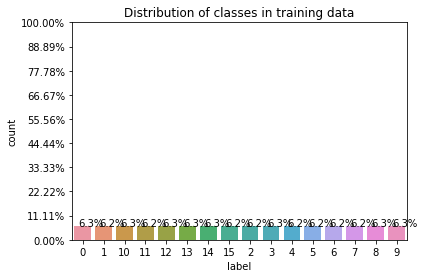

In [20]:
Y=train_label
total = len(Y)
ax=sns.countplot(x=Y.label, data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.2, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 10))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.2f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.title('Distribution of classes in training data')
plt.show()

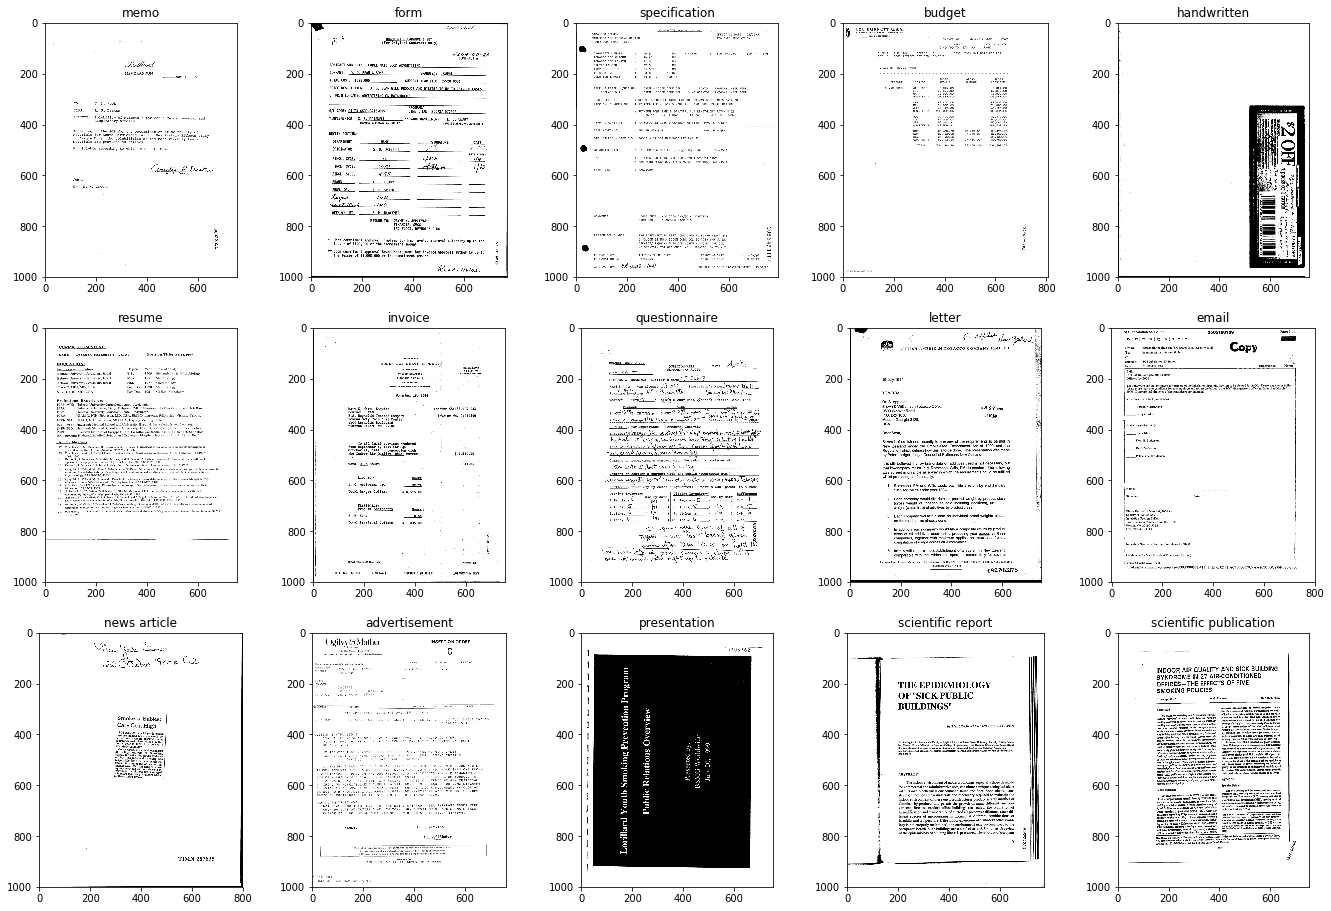

In [24]:
# sample from all the classes
files=os.listdir(train_dir)
labels=[]
sample_files=[]
count=0
for i in range(len(train_label)):
    if(train_label.iloc[i].label not in labels):
        if(len(labels)<16):
            sample_files.append('train_consolidated/'+train_label.iloc[i].path.split('/')[-1])
            labels.append(train_label.iloc[i].label)
    if(len(labels)>15):
        break      
fig,ax=plt.subplots(3,5)
fig.subplots_adjust(0,0,3,3)
index=0
for i in range(0,3):
    for j in range(0,5):
        pt=plt.imread(sample_files[index])
        ax[i,j].imshow(pt,cmap='gray')
        ax[i,j].set_title(classes[str(labels[index])])
        index+=1

In [25]:
from skimage import io

#--- Mean pixel Intensity= (sum of all pixel values)/no of pixel values
def extract_image_size_and_mean_pixel_intensity(files):
    print('We will start extracting file size and mean pixel intensity of each files.')
    file_size=[]
    mean_pixel=[]
    print('Extraction begins..')
    start_time = time.time()
    for file in tqdm(files):
        mean_pixel.append(np.mean(io.imread(file)))
        file_size.append(os.stat(file).st_size/(1024.0*1024.0))
    print('Feature extaction completed.')
    print('Time elapsed(in hour):',(time.time() - start_time)/3600)
    print('-'*50)
    return file_size,mean_pixel
    

In [ ]:
test_file_size,test_mean_pixel=extract_image_size_and_mean_pixel_intensity(test_label.path)
val_file_size,val_mean_pixel=extract_image_size_and_mean_pixel_intensity(val_label.path)

In [26]:
train_label=pd.read_csv('train_label.csv')
train_label=train_label.drop(columns=['Unnamed: 0'])
test_label=pd.read_csv('test_label.csv')
test_label=test_label.drop(columns=['Unnamed: 0'])
val_label=pd.read_csv('val_label.csv')
val_label=val_label.drop(columns=['Unnamed: 0'])
val_label.head()

,path,label,file_size,mean_pixel
0,val/2024525661.tif,11,0.113686,243.770072
1,val/512015827+-5827.tif,0,0.127718,239.048753
2,val/87103403.tif,0,0.075228,244.634381
3,val/03636607.tif,4,0.102934,243.514163
4,val/50437856-7857.tif,14,0.137114,242.180621


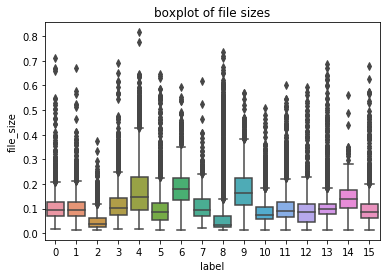

In [27]:
# boxplot of file sizes
ax = sns.boxplot(x="label", y="file_size", data=test_label)
plt.title("boxplot of file sizes")
plt.show()

From the boxplot we can observe that size of some type of scanned documents are quiet different than others, but there are also overlaps. For example, the file size of class 13 and class 9 are much different but size of class 9 overlaps with class 4 and class 6,7.

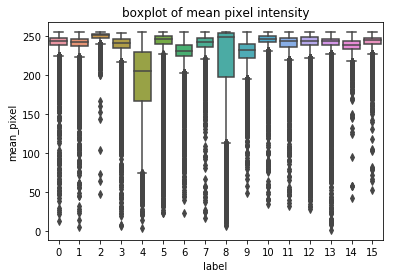

In [28]:
# Boxplot of mean pixel intensity
ax = sns.boxplot(x="label", y="mean_pixel", data=train_label)
plt.title("boxplot of mean pixel intensity")
plt.show()

We can observe that for 75% of the cases, mean pixel intensity of class 4 lies between 160-230 pixels.But for approx 50% cases it also overlaps with mean pixel value of class 6. For other classes, mean pixel value overlaps.

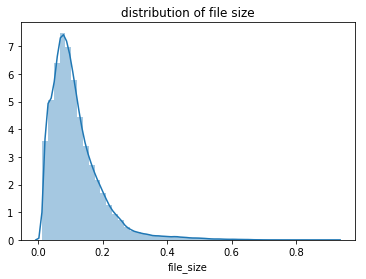

In [32]:
sns.distplot(train_label.file_size)
plt.title("distribution of file size")
plt.show()

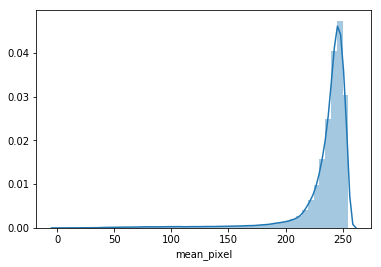

In [33]:
sns.distplot(train_label.mean_pixel)

### Training Stretegy

We will use CNN(Convolution Neural Networks) to address the problem.Instead of developing our own model from scratch we will use transfer learning (here we will use models pretrined on ImageNet).The current SOTA model for this genere of problem uses inter and intra domain transfer learning where an image is divided in to four parts header,footer,left body and right body. A pretrained vgg16 model is first used to train over the whole images(inter domain) then this model is used to train the part of images(Intra domain).

In this experiment we will take a different approach. Instead of intradomain trainsfer learning using vgg16, we will develope two parallel models VGG16 and InceptionResNetV2 and will stack the model.Our assumtion is that because of the different structure of these two models they will learn the different ascept of images and stacking them will result good generalization.

<b> How hyperparameters will be tuned?</b>
For any CNN the hypermeters are : pooling size, network size, batch size,choice of optimizers, learning rate,regularization,input size etc.                                                                                     
To keep the main notebook neet we will do this experiments discreatly. We have develope some utility functions in <b>paramtune.ipynb</b> notebook. Suppose after 10 epoch we got an accuacy of 47%. We will use this model as testing baseline at that point and using the utility funtions we will check which configuration set(i.e. bach_size/optimizer/learning_rate) will result better accuracy in future epochs.

#### Vgg16 Architecture:

<img src="vgg16.png">

#### InseptionResnetv2 Architecture:

<img src="ins.png">

### Training Configuration

In [0]:
# Training configuaration for CNN- to be trained on whole images
img_width, img_height = 224,224
train_dir = "train/Whole"
val_dir = "val/Whole"
test_dir="test"
nb_train_samples = 320000
nb_validation_samples = 40000 
batch_size = 50
epochs = 20
num_classes=16
log=[]

#### Training and Validation Data generator on the flow:

In [22]:
# preparing Training and Validation data using ImageDataGenerator
train_datagen = ImageDataGenerator(
rescale = 1./255,
featurewise_std_normalization=True)

val_datagen = ImageDataGenerator(
rescale = 1./255,
featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

val_generator = val_datagen.flow_from_directory(
val_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 319837 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.


#### Transfer learning using pretrained InceptionResNetv2 (ImageNet weights)

In [0]:
# Importing keras InceptionRsnetv2 pretrained model (on ImageNet)
# We will use the ImageNet weight to initialize the model and fine tune using backpropagation(Transfer Learning) 
from keras import regularizers
model=applications.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
#for layer in model.layers[:15]:
#    layer.trainable = False
#Adding custom Layers 
x = model.output
x=Dropout(0.5)(x)
x = Flatten()(x)
output = Dense(num_classes, activation="softmax")(x)
model = Model(input = model.input, output = output)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 111, 111, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 111, 111, 32) 0           batch_normalization_204[0][0]    
____________________________________________________________________________________________

In [0]:
# Training for 30 epochs
from keras.callbacks import ReduceLROnPlateau
#model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
checkpoint = ModelCheckpoint("inceptionresnet.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.0001,mode='auto')
callbacks=[checkpoint,reduce_lr]
history=model.fit_generator(
train_generator,
samples_per_epoch =5000,
epochs = 20,
validation_data = val_generator,
validation_steps =math.ceil(3000//(batch_size)),
callbacks = callbacks,verbose=1)
log.append(history)

Epoch 1/20
100/100 [==============================] - 138s 1s/step - loss: 0.9115 - acc: 0.7880 - val_loss: 0.7323 - val_acc: 0.8053

Epoch 00001: val_acc improved from -inf to 0.80533, saving model to inceptionresnet.h5
Epoch 2/20
100/100 [==============================] - 81s 809ms/step - loss: 0.9392 - acc: 0.7884 - val_loss: 0.7285 - val_acc: 0.8070

Epoch 00002: val_acc improved from 0.80533 to 0.80700, saving model to inceptionresnet.h5
Epoch 3/20
100/100 [==============================] - 81s 808ms/step - loss: 0.9115 - acc: 0.7916 - val_loss: 0.8066 - val_acc: 0.8083

Epoch 00003: val_acc improved from 0.80700 to 0.80833, saving model to inceptionresnet.h5
Epoch 4/20
100/100 [==============================] - 81s 807ms/step - loss: 0.8932 - acc: 0.7926 - val_loss: 0.8221 - val_acc: 0.7957

Epoch 00004: val_acc did not improve from 0.80833
Epoch 5/20
100/100 [==============================] - 83s 830ms/step - loss: 0.9381 - acc: 0.7874 - val_loss: 0.7988 - val_acc: 0.7980

Epoch

In [0]:
model.save('drive/My Drive/resinception_1.h5')

In [0]:
history1=model.fit_generator(
train_generator,
samples_per_epoch =10000,
epochs = 30,
validation_data = val_generator,
validation_steps =math.ceil(10000//(batch_size*2)),
callbacks = callbacks,verbose=1)
log.append(history)

Epoch 1/30
200/200 [==============================] - 160s 799ms/step - loss: 0.8834 - acc: 0.8017 - val_loss: 0.7614 - val_acc: 0.8138

Epoch 00001: val_acc did not improve from 0.82104
Epoch 2/30
200/200 [==============================] - 158s 792ms/step - loss: 0.8872 - acc: 0.8038 - val_loss: 0.7734 - val_acc: 0.8104

Epoch 00002: val_acc did not improve from 0.82104
Epoch 3/30
200/200 [==============================] - 158s 789ms/step - loss: 0.8759 - acc: 0.8069 - val_loss: 0.8688 - val_acc: 0.8098

Epoch 00003: val_acc did not improve from 0.82104
Epoch 4/30
200/200 [==============================] - 158s 792ms/step - loss: 0.8714 - acc: 0.8030 - val_loss: 0.6859 - val_acc: 0.8096

Epoch 00004: val_acc did not improve from 0.82104
Epoch 5/30
200/200 [==============================] - 157s 787ms/step - loss: 0.8522 - acc: 0.8057 - val_loss: 0.6882 - val_acc: 0.8128

Epoch 00005: val_acc did not improve from 0.82104
Epoch 6/30
200/200 [==============================] - 158s 792ms/

In [0]:
model.save('drive/My Drive/resinception_85.h5')

In [0]:
batch_size=50
history2=model.fit_generator(
train_generator,
samples_per_epoch =10000,
epochs = 20,
validation_data = val_generator,
validation_steps =math.ceil(10000//(batch_size*2)),
callbacks = callbacks,verbose=1)
log.append(history)

Epoch 1/20
200/200 [==============================] - 161s 807ms/step - loss: 0.5602 - acc: 0.8473 - val_loss: 0.5642 - val_acc: 0.8422

Epoch 00001: val_acc did not improve from 0.84600
Epoch 2/20
200/200 [==============================] - 159s 793ms/step - loss: 0.5484 - acc: 0.8511 - val_loss: 0.5589 - val_acc: 0.8472

Epoch 00002: val_acc improved from 0.84600 to 0.84720, saving model to inceptionresnet.h5
Epoch 3/20
200/200 [==============================] - 158s 790ms/step - loss: 0.5929 - acc: 0.8446 - val_loss: 0.5672 - val_acc: 0.8404

Epoch 00003: val_acc did not improve from 0.84720
Epoch 4/20
200/200 [==============================] - 160s 798ms/step - loss: 0.5688 - acc: 0.8525 - val_loss: 0.5583 - val_acc: 0.8418

Epoch 00004: val_acc did not improve from 0.84720
Epoch 5/20
200/200 [==============================] - 158s 791ms/step - loss: 0.5565 - acc: 0.8499 - val_loss: 0.5630 - val_acc: 0.8462

Epoch 00005: val_acc did not improve from 0.84720
Epoch 6/20
200/200 [=====

In [33]:
ins_acc=0.85340

#### Visualization of loss and accuracy  at various training stage:

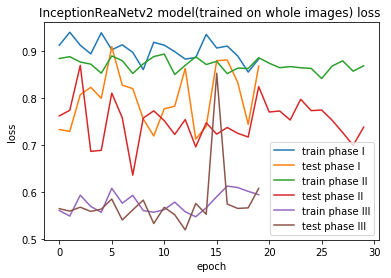

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('InceptionReaNetv2 model(trained on whole images) loss ')
plt.ylabel('loss')
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('epoch')
plt.legend(['train phase I', 'test phase I','train phase II', 'test phase II','train phase III', 'test phase III'], loc='lower right')
plt.show()

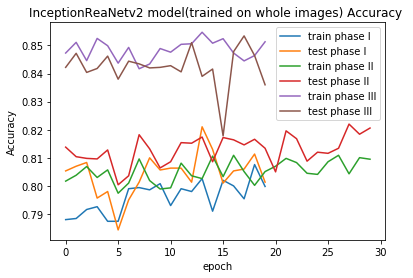

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('InceptionReaNetv2 model(trained on whole images) Accuracy ')
plt.ylabel('Accuracy')
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('epoch')
plt.legend(['train phase I', 'test phase I','train phase II', 'test phase II','train phase III', 'test phase III'], loc='upper right')
plt.show()

#### Transfer learning using pretrained Vgg16 (ImageNet weights)

In [0]:
# Importing keras VGG16 pretrained model (on ImageNet)
# We will use the ImageNet weight to initialize the model and fine tune using backpropagation(Transfer Learning) 
from keras import regularizers
model=applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
#for layer in model.layers[:15]:
#    layer.trainable = False
#Adding custom Layers 
x = model.output
x = Flatten()(x)
output = Dense(num_classes, activation="softmax")(x)
model = Model(input = model.input, output = output)
model.summary()





58892288/58889256 [==============================] - 2s 0us/step




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________

In [0]:
from keras.models import load_model
checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
callbacks=[checkpoint]

In [0]:
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [0]:
# Training for 30 epochs
history=model.fit_generator(
train_generator,
samples_per_epoch =50000,
epochs = 30,
validation_data = val_generator,
validation_steps =math.ceil(30000//(batch_size*2)),
callbacks = callbacks,verbose=1)
log.append(history)

Epoch 1/30
781/781 [==============================] - 641s 821ms/step - loss: 1.9073 - acc: 0.4058 - val_loss: 1.4093 - val_acc: 0.5759

Epoch 00001: val_acc improved from -inf to 0.57585, saving model to vgg16.h5
Epoch 2/30
781/781 [==============================] - 623s 798ms/step - loss: 1.2707 - acc: 0.6130 - val_loss: 1.1460 - val_acc: 0.6513

Epoch 00002: val_acc improved from 0.57585 to 0.65131, saving model to vgg16.h5
Epoch 3/30
781/781 [==============================] - 623s 798ms/step - loss: 1.1073 - acc: 0.6612 - val_loss: 1.0650 - val_acc: 0.6770

Epoch 00003: val_acc improved from 0.65131 to 0.67704, saving model to vgg16.h5
Epoch 4/30
781/781 [==============================] - 624s 799ms/step - loss: 0.9979 - acc: 0.6973 - val_loss: 0.9355 - val_acc: 0.7173

Epoch 00004: val_acc improved from 0.67704 to 0.71728, saving model to vgg16.h5
Epoch 5/30
781/781 [==============================] - 629s 805ms/step - loss: 0.9227 - acc: 0.7205 - val_loss: 0.8741 - val_acc: 0.7360

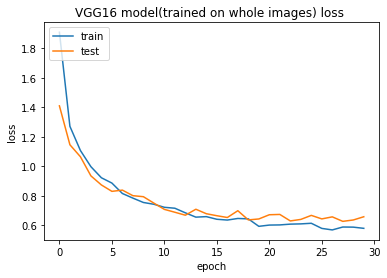

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 model(trained on whole images) loss ')
plt.ylabel('loss')
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

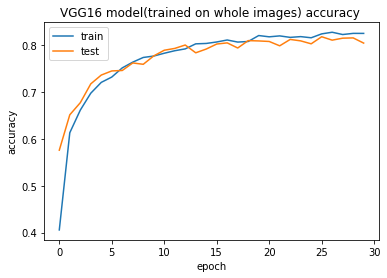

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 model(trained on whole images) accuracy ')
plt.ylabel('accuracy')
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
backup_model=model

In [0]:
# saving training log for first 30 epochs
model.save('vgg16_whole.h5')
with open('log.pkl', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

After running for 30 epochs with adam optimizer, we obtained an accuracy of 82%. We can see that the loss is not improving over last four epochs.We will train the network for 10 more epochs with adam optimizer and decaying learning rate. If  val_acc does not improve in 3 epochs we will reduce the learning rate automatically using callback.   

In [0]:
from keras.callbacks import ReduceLROnPlateau
#model.compile(loss = "categorical_crossentropy", optimizer = 'adamax', metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.0001,mode='auto')
callbacks=[checkpoint,reduce_lr]
history1=model.fit_generator(
train_generator,
samples_per_epoch =50000,
epochs = 10,
validation_data = val_generator,
validation_steps =math.ceil(30000//(batch_size*2)),
callbacks = callbacks,verbose=1)


Epoch 1/10
781/781 [==============================] - 624s 798ms/step - loss: 0.4667 - acc: 0.8595 - val_loss: 0.5828 - val_acc: 0.8316

Epoch 00001: val_acc improved from 0.81778 to 0.83160, saving model to vgg16.h5
Epoch 2/10
781/781 [==============================] - 609s 780ms/step - loss: 0.4565 - acc: 0.8619 - val_loss: 0.5692 - val_acc: 0.8348

Epoch 00002: val_acc improved from 0.83160 to 0.83480, saving model to vgg16.h5
Epoch 3/10
781/781 [==============================] - 604s 774ms/step - loss: 0.4678 - acc: 0.8580 - val_loss: 0.5614 - val_acc: 0.8332

Epoch 00003: val_acc did not improve from 0.83480
Epoch 4/10
781/781 [==============================] - 608s 778ms/step - loss: 0.4649 - acc: 0.8582 - val_loss: 0.5654 - val_acc: 0.8369

Epoch 00004: val_acc improved from 0.83480 to 0.83694, saving model to vgg16.h5
Epoch 5/10
781/781 [==============================] - 606s 776ms/step - loss: 0.4583 - acc: 0.8620 - val_loss: 0.5379 - val_acc: 0.8421

Epoch 00005: val_acc impr

In [32]:
vgg_acc=0.8513

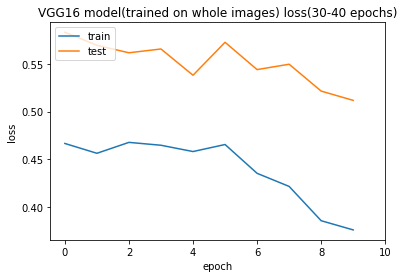

In [0]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('VGG16 model(trained on whole images) loss(30-40 epochs)')
plt.ylabel('loss')
plt.xticks([0,2,4,6,8,10])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

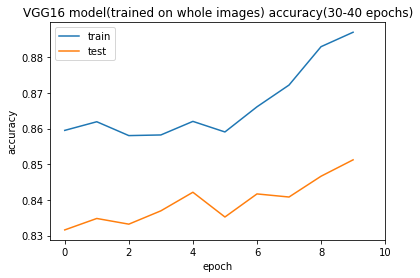

In [0]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('VGG16 model(trained on whole images) accuracy(30-40 epochs)')
plt.ylabel('accuracy')
plt.xticks([0,2,4,6,8,10])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Stacking Models and Evaluation

In [7]:
img_width, img_height = 224,224
train_dir = "train"
val_dir = "val"
test_dir="test"
nb_train_samples = 300000
nb_validation_samples = 32000
batch_size = 128
epochs = 20
num_classes=16
log=[]

In [19]:
# Test Data generator to generate test data in same format of training data
test_datagen = ImageDataGenerator(
rescale = 1./255,
featurewise_std_normalization=True)
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size = (img_height, img_width),
batch_size = batch_size,shuffle='True',
class_mode = "categorical")

Found 39997 images belonging to 16 classes.


In [2]:
from keras.models import load_model
#!cp 'drive/My Drive/vgg16_85.h5' 'vgg16_85.h5'
#!cp 'drive/My Drive/resinception_85.h5' 'Inception_resnet.h5'
model1=load_model('vgg16_85.h5')
model2=load_model('Inception_resnet.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels
def eval_model(model1,model2,test_generator,limit):
    """
    This function creates an ensamble of candidate CNN models and predict the result
    model1,model2 -- candidate models
    test_generator -- Instance of ItemDataGenerator to randomly generate test data
    limit -- limits the number of test samples
    
    """
    try:
         x,y=test_generator.next()
    except:
        print('data loading failed.')
        break
    y_pred=[]
    y_true=[]
    count=0
    for i in range(len(x)):
        pred1=model1.predict(np.expand_dims(x[i], axis=0))
        pred2=model2.predict(np.expand_dims(x[i], axis=0))
        try:
            # we will concatenate the predictions of two models
            predicted_y=np.argmax(pred1+pred2)
            y_pred.append(predicted_y)
        except:
            print('Some error occured.')
            y_pred.append(np.argmax(pred2))
        y_true.append(np.argmax(y[i]))
        count+=1
        # limit the number of samples to be considered
        if(count==limit):
            break
    return y_pred,y_true

def get_result(y_pred,y_true):
    """
    This function evaluate the performance(accuracy,f1-score,precision,recall,confusion matrix of the network).
    """
    print('-----Model Evaluation------')
    accuracy=np.round(accuracy_score(y_pred,y_true),3)
    f1=np.round(f1_score(y_pred,y_true,average='macro'),3)
    precision=np.round(precision_score(y_pred,y_true,average='macro'),3)
    recall=np.round(recall_score(y_pred,y_true,average='macro'),3)
    print('Accuracy:',(accuracy)*100,'%')
    print('Macro F1 Score:',f1)
    print('Precision Score:',precision)
    print('Recall Score:',recall)
    plot_confusion_matrix(y_true,y_pred)
    return accuracy,f1,precision,recall
    

In [10]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(17,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(17,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(17,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

-----Model Evaluation------
Accuracy: 89.2 %
Macro F1 Score: 0.894
Precision Score: 0.889
Recall Score: 0.888
-------------------------------------------------- Confusion matrix --------------------------------------------------


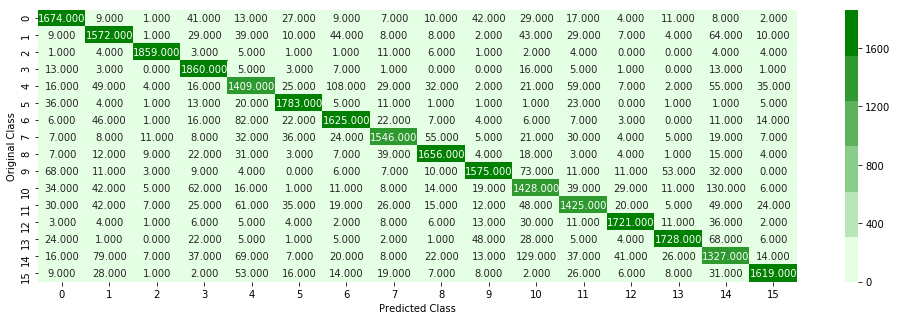

-------------------------------------------------- Precision matrix --------------------------------------------------


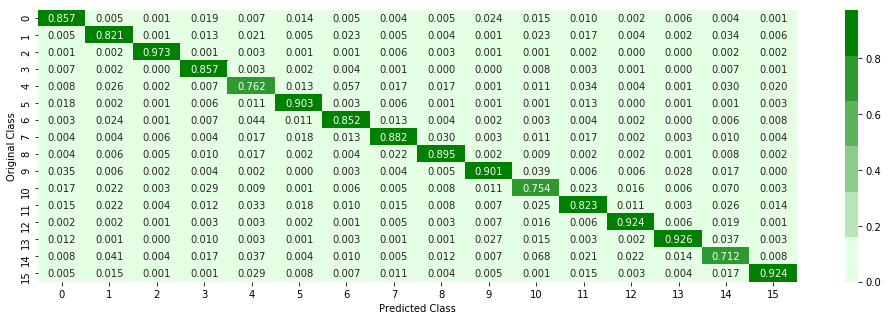

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


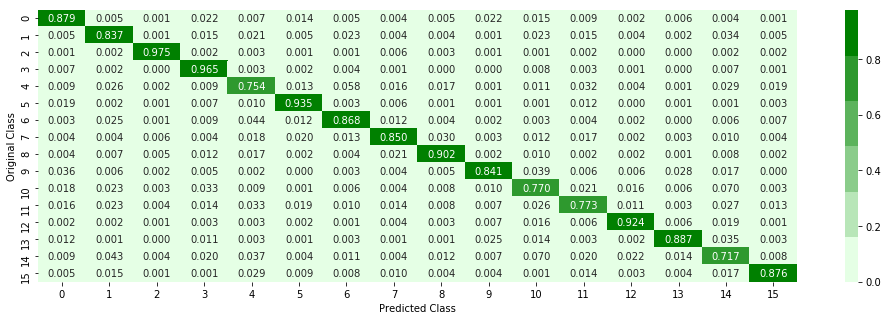

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
y_pred,y_true=eval_model(model1,model1,test_generator,30000)
accuracy,f1,precision,recall=get_result(y_pred,y_true)

In [19]:
# compare 10 results from tail
res=pd.read_csv('res.csv')
res_=res.drop('Unnamed: 0',axis=1)
res_.tail(10)

,y_true,y_pred
29990,11,11
29991,0,0
29992,14,11
29993,15,15
29994,1,1
29995,3,3
29996,11,11
29997,10,10
29998,10,10
29999,10,10


In [43]:
from keras.models import load_model
model1=load_model('vgg16.h5')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Text(0.5, 1.0, 'Test Accuracy of various models')

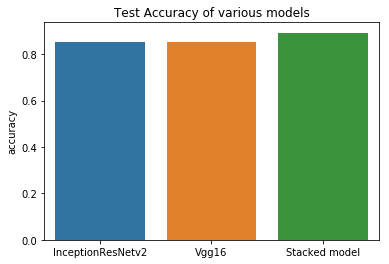

In [38]:
x=['InceptionResNetv2','Vgg16','Stacked model']
y=[ins_acc,vgg_acc,accuracy]
sns.barplot(x,y)
plt.ylabel('accuracy')
plt.title('Test Accuracy of various models')

### Conslusion:

Using the stack generalization of vgg16 and IncaptionResNetv2 we can get a decent accuracy of 89%. But the current SOTA approach still provides better  accuracy of 91.2%. We still have scope of improvement through further experiments.